In [1]:
from models.model_v1 import *
from data.midi_preprocessing import *

/usr/lib/python3.13/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Create the GAN.
model = GAN()

data_file_path = "data/preprocessed/maestro-v3.0.0/dataset1/50K_dataset.h5"
dm = MaestroV3DataModule(data_file_path)

# Train the net.
trainer = L.Trainer(
    #enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=1,
)
trainer.fit(model, dm)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4070 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode  | In sizes | Out sizes      
-------------------------------------------------------------------------------------


Epoch 0: 100%|███████████████████████████████████████| 1546/1546 [07:37<00:00,  3.38it/s, v_num=32, g_loss=0.693, d_loss=1.010]                                                                                                                                 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|███████████████████████████████████████| 1546/1546 [07:37<00:00,  3.38it/s, v_num=32, g_loss=0.693, d_loss=1.010]


In [8]:
# Generate a sample.
z_lst = []
for _ in range(10):
    noise = torch.randn(1, 100)
    #print(noise)
    z_lst.append(noise)
hat_y = []
for z in z_lst:
    hat_y.append(model(z))
#print((hat_y>0).sum())
#hat_y = hat_y.squeeze(0, 1)
#print(hat_y.shape)
#print(hat_y)
#print((hat_y > 0).sum())

(128, 16)


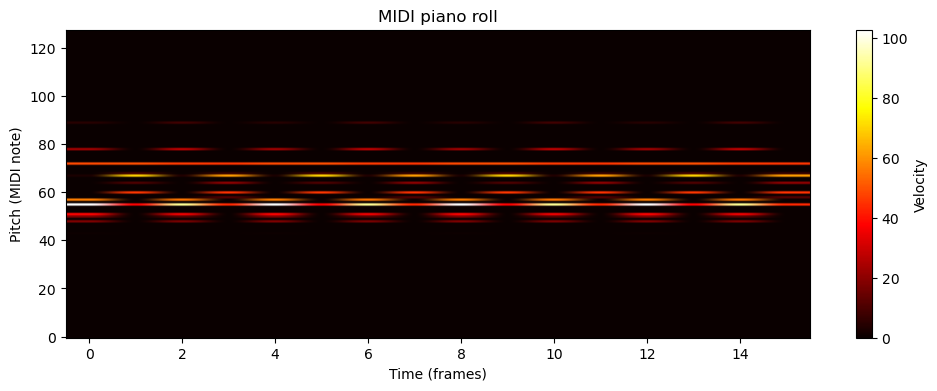

(128, 16)


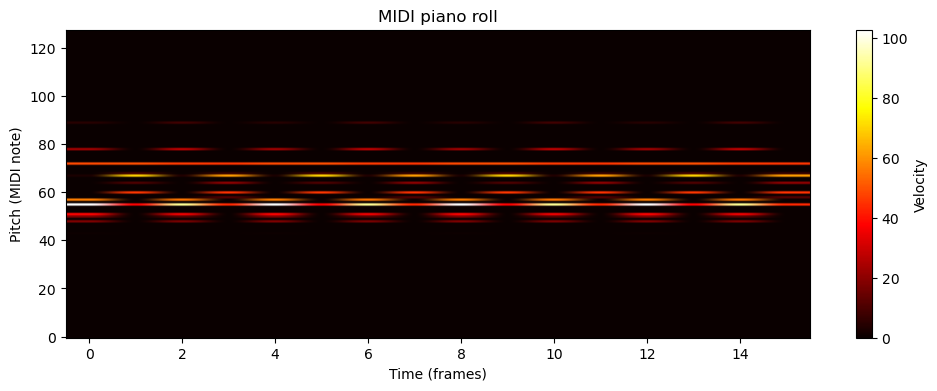

(128, 16)


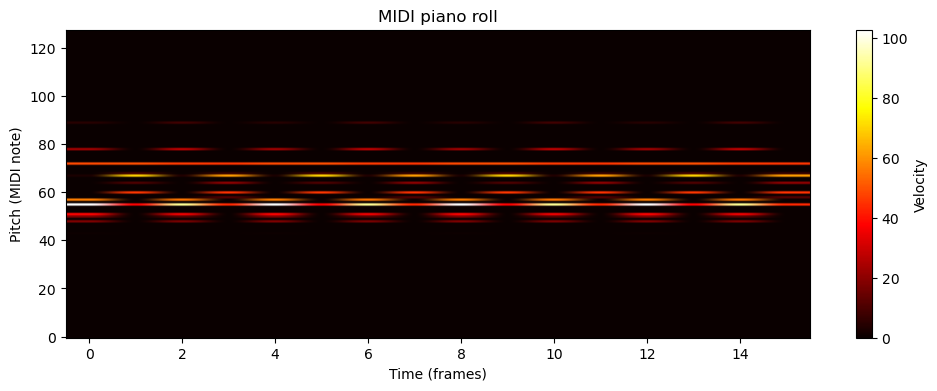

(128, 16)


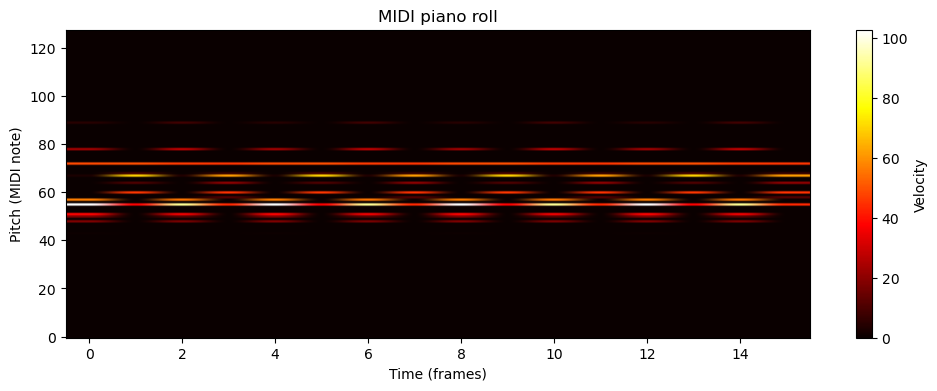

(128, 16)


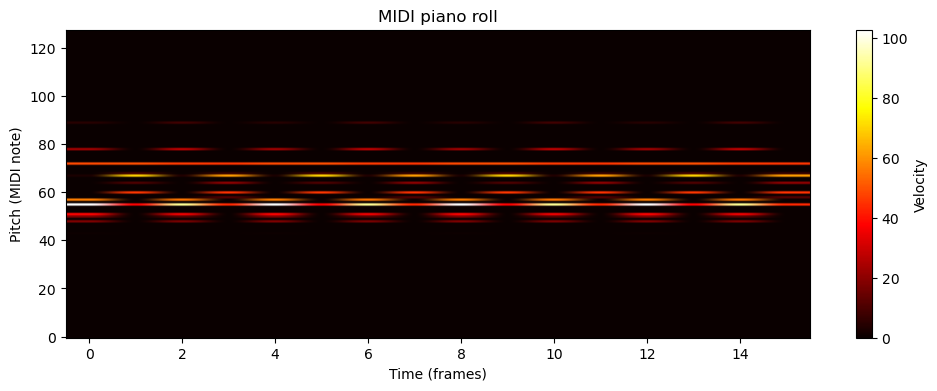

(128, 16)


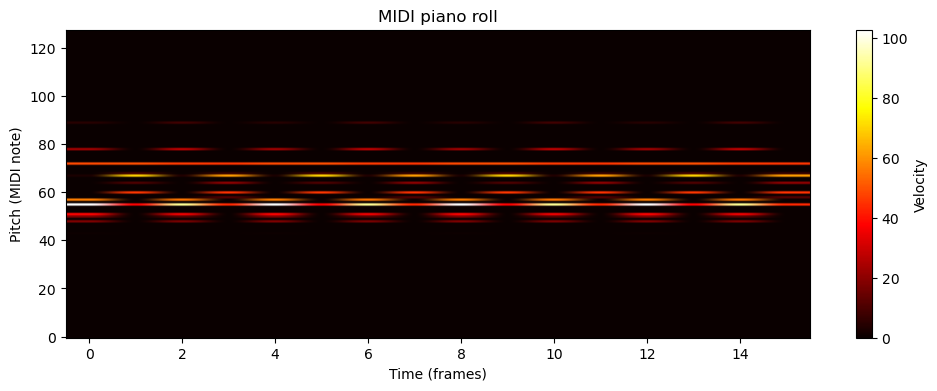

(128, 16)


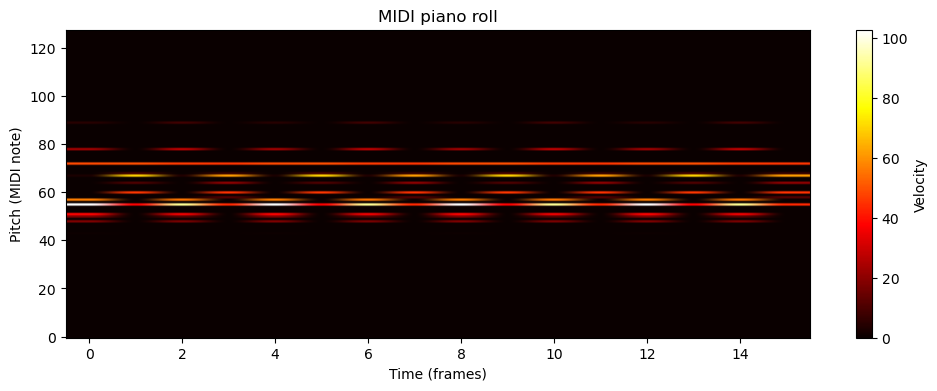

(128, 16)


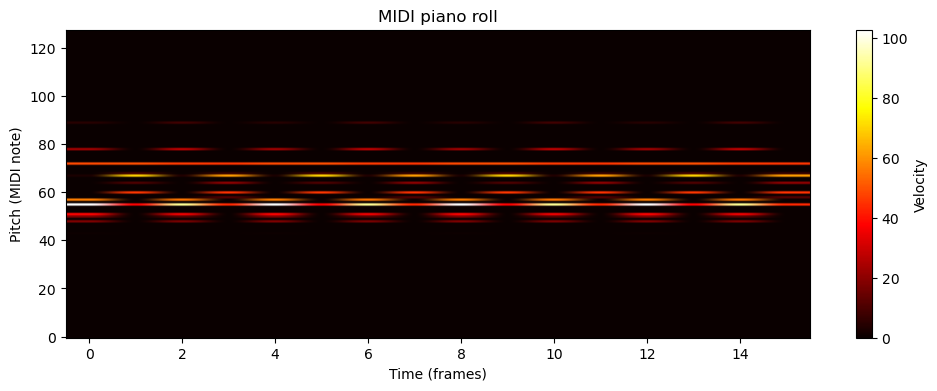

(128, 16)


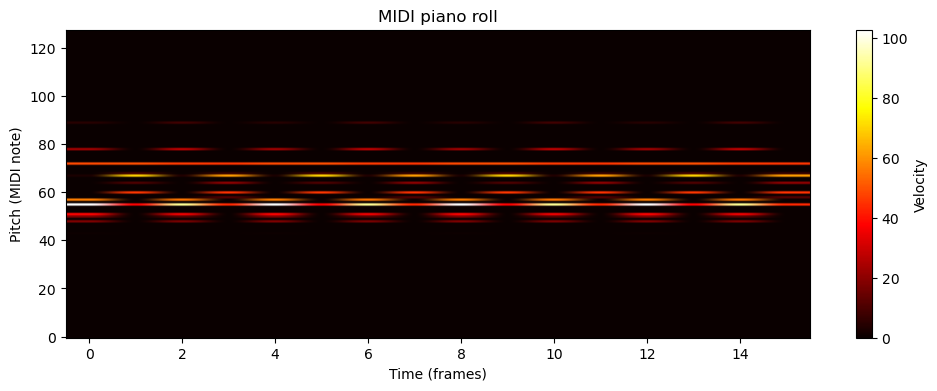

(128, 16)


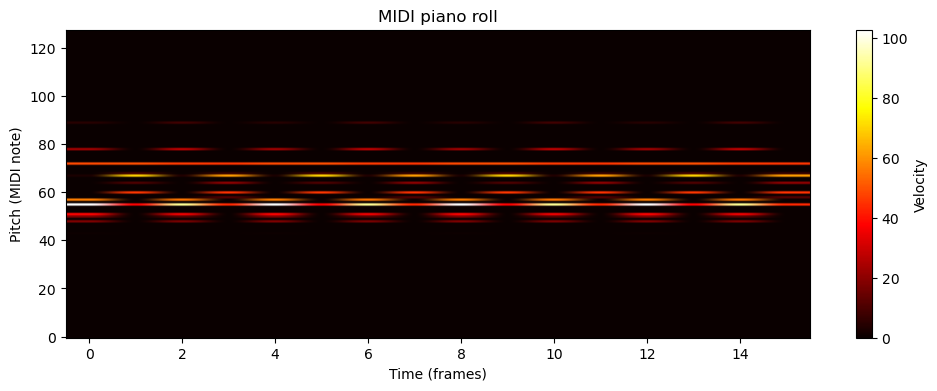

In [9]:
pr_lst = []
for i, y in enumerate(hat_y):
    y = y.squeeze(0, 1)
    pr = y.detach().numpy()
    pr *= 50
    print(pr.shape)
    show_piano_roll(pr)
    midi_file = piano_roll_to_pretty_midi(pr, fs=8)
    
    filename = "output_ex" + str(i) + ".midi"
    midi_file.write(filename)
    pr_lst.append(pr)

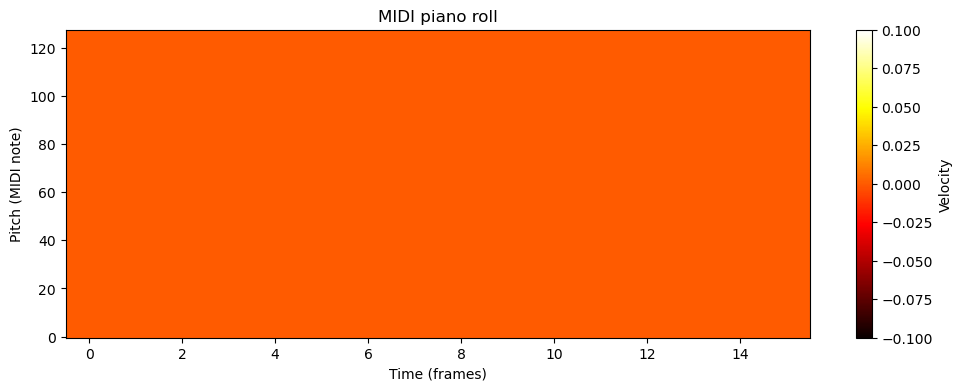

In [10]:
#tensor = model(z_lst[0])
#tensor = tensor.squeeze(0, 1)
#(tensor > 0).sum()

diff = pr_lst[1] - pr_lst[0]
show_piano_roll(diff)

In [ ]:
def ascolta_midi(file_midi: str):
    """
    Riproduce un file MIDI utilizzando pygame.

    Args:
        file_midi (str): Il percorso del file .mid da riprodurre.
    """
    try:
        # Inizializza il mixer di pygame
        # I valori sono standard: frequenza, bit, canali, dimensione del buffer
        pygame.mixer.init(44100, -16, 2, 512)

        pygame.init()

        print(f"🎵 Riproduzione di '{file_midi}'...")

        # Carica e riproduci il file MIDI
        pygame.mixer.music.load(file_midi)
        pygame.mixer.music.play()

        # Attendi che la musica finisca
        # Mantiene lo script attivo finché la musica è in riproduzione
        while pygame.mixer.music.get_busy():
            time.sleep(0.1)

    except pygame.error as e:
        print(f"Errore di pygame: {e}")
        print("Assicurati che il file MIDI sia valido e che i driver audio funzionino.")
    except FileNotFoundError:
        print(f"Errore: File non trovato all'indirizzo '{file_midi}'")
    finally:
        # Pulisci e chiudi pygame per liberare le risorse
        if pygame.get_init():
            pygame.mixer.music.stop()
            pygame.mixer.quit()
            pygame.quit()
        print("Riproduzione terminata.")

In [ ]:
ascolta_midi("ouput_ex.midi")

In [ ]:
# Istanzia il modello
model_to_train = SimpleClassifier(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, learning_rate=LEARNING_RATE)

# Crea una cartella per i checkpoint se non esiste
checkpoint_dir = "my_training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback per salvare il checkpoint finale
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="my_model-{epoch:02d}",
    save_last=True # Salva l'ultimo checkpoint al termine
)

# Trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    callbacks=[checkpoint_callback],
    logger=False # Per questo esempio, disabilitiamo il logger per semplicità
)

print("\n--- Inizio del training ---")
trainer.fit(model_to_train, dataloader)
print("--- Training completato ---")

# Trova il percorso dell'ultimo checkpoint salvato
last_checkpoint_path = checkpoint_callback.last_model_path
print(f"\nCheckpoint salvato in: {last_checkpoint_path}")

# 4. Caricamento del Modello e degli Iperparametri dal Checkpoint

print("\n--- Caricamento del modello dal checkpoint ---")

# Metodo 1: Caricare il checkpoint raw e accedere agli iperparametri
# Questo è utile se vuoi solo leggere gli iperparametri senza istanziare subito il modello
checkpoint_dict = torch.load(last_checkpoint_path, map_location=lambda storage, loc: storage)

print(f"Iperparametri salvati: {checkpoint_dict.get('hyper_parameters', 'Chiave non trovata, prova "hparams"')}")
# Le versioni più recenti di Lightning usano 'hparams', le vecchie 'hyper_parameters'
# Quindi potresti voler usare .get('hparams', checkpoint_dict.get('hyper_parameters')) o controllare

print(f"Iperparametri specifici: Input Dim={checkpoint_dict['hyper_parameters']['input_dim']}, "
      f"Hidden Dim={checkpoint_dict['hyper_parameters']['hidden_dim']}, "
      f"Learning Rate={checkpoint_dict['hyper_parameters']['learning_rate']}")


# Metodo 2 (Raccomandato): Caricare direttamente il LightningModule dal checkpoint
# Questo re-instanza il tuo LightningModule con gli iperparametri salvati
# e carica i pesi del modello.
loaded_model = SimpleClassifier.load_from_checkpoint(last_checkpoint_path)

print(f"\nModello caricato con successo. Iperparametri recuperati da .hparams: {loaded_model.hparams}")
print(f"Tipo di Learning Rate nel modello caricato: {loaded_model.hparams.learning_rate}")

# Puoi accedere ai pesi del modello caricato
# print(loaded_model.state_dict())

# Ora puoi usare 'loaded_model' per inferenza o continuare il training
loaded_model.eval() # Imposta il modello in modalità valutazione
sample_input = torch.randn(1, INPUT_DIM)
output = loaded_model(sample_input)
print(f"\nOutput di esempio dal modello caricato: {output.item():.4f}")

# Simulare un nuovo training partendo dal checkpoint (opzionale)
# new_trainer = pl.Trainer(max_epochs=10, logger=False) # Continua per altre 5 epoche (tot 10)
# new_trainer.fit(loaded_model, dataloader, ckpt_path=last_checkpoint_path) # Riprende dal checkpoint

# Pulizia (opzionale)
# import shutil
# if os.path.exists(checkpoint_dir):
#     shutil.rmtree(checkpoint_dir)